# **Oleksiy's Problog Agent Analysis**

### Libraries


In [ ]:
import json
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import piplite
await piplite.install("seaborn")
import seaborn as sns


def analyse(path_file):
    """
        Perform analysis on the match files in the given path.
        The analysis includes:
        - Win rate
        - Loss rate
        - Overall match outcome distribution
        - Landslide match outcome distribution
        - Match outcomes
        - Average damage per round
        - Action usage frequency
        - Round duration distribution
        - Remaining HP distribution
        - Correlation between round metrics
        - Damage efficiency distribution
        - Damage dealt vs received over time

        Parameters:
        path_file (str): Path to the match files

        Returns:
        None
    """
    match_files = glob.glob(path_file)
    match_stats = []
    round_stats = []
    
    # Data loading remains the same
    for file in match_files:
        with open(file, 'r') as f:
            data = json.load(f)
            match_stats.append({
                'wins': data['wins'],
                'losses': data['losses'],
                'draws': data['draws'],
                'total_rounds': data['total_rounds_played'],
                'duration': data['duration']
            })
            for round in data['rounds']:
                round_stats.append({
                    'duration': round['duration'],
                    'damage_dealt': round['damage_dealt'],
                    'damage_received': round['damage_received'],
                    'actions_used': round['actions_used'],
                    'remaining_hp': round['my_hps'][-1],
                    'opponent_remaining_hp': round['opponent_hps'][-1]
                })

    matches_df = pd.DataFrame(match_stats)
    rounds_df = pd.DataFrame(round_stats)

    # Print statistics
    num_won = matches_df[matches_df['wins'] > 1].shape[0]
    num_lost = matches_df[matches_df['losses'] > 1].shape[0]
    
    print(f"Win Rate: {num_won / len(matches_df) * 100:.2f}%")
    print(f"Loss Rate: {num_lost / len(matches_df) * 100:.2f}%")

    # Create the main figure first - Changed to 6x2 grid
    fig = plt.figure(figsize=(20, 30))  # Increased height to accommodate extra row
    
    # Plot 1: Overall Match outcome distribution
    ax1 = plt.subplot(6, 2, 1)  # Changed from 5,2 to 6,2
    matches_df['outcome'] = matches_df.apply(
        lambda x: 'Win' if x['wins'] > x['losses'] 
        else ('Draw' if x['wins'] == x['losses'] else 'Loss'), axis=1)
    matches_df['outcome'].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=ax1)
    ax1.tick_params(axis='x', rotation=45, which='both',
                length=4,
                direction='in')
    ax1.set_title('Overall Match Outcome Distribution')

    # Plot 2: Landslide outcomes
    ax2 = plt.subplot(6, 2, 2)  # Changed from 5,2 to 6,2
    matches_df['outcome'] = matches_df.apply(
        lambda x: 'Landslide Win' if x['wins'] == 3 
        else ('Landslide Loss' if x['losses'] == 3 else 'Non'), axis=1)
    matches_df['outcome'].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=ax2)
    ax2.set_title('Landslide Match Outcome Distribution')
    
    # Rest of the plots - All changed from 5,2 to 6,2
    ax3 = plt.subplot(6, 2, 3)
    matches_df[['wins', 'losses', 'draws']].sum().plot(kind='bar', ax=ax3)
    ax3.set_title('Match Outcomes')
    ax3.set_ylabel('Count')

    ax4 = plt.subplot(6, 2, 4)
    rounds_df[['damage_dealt', 'damage_received']].mean().plot(kind='bar', ax=ax4)
    ax4.set_title('Average Damage per Round')
    ax4.set_ylabel('Damage')

    ax5 = plt.subplot(6, 2, (5,6))
    action_counts = pd.Series([x for sublist in rounds_df['actions_used'] for x in sublist]).value_counts()
    action_counts.index = [x.replace('_', ' ').title() for x in action_counts.index]
    action_counts.plot(kind='bar', ax=ax5)
    ax5.set_title('Action Usage Frequency')
    ax5.tick_params(axis='x', rotation=45)
    ax5.set_ylabel('Count')

    ax6 = plt.subplot(6, 2, 7)
    rounds_df['duration'].hist(bins=20, ax=ax6)
    ax6.set_title('Round Duration Distribution')
    ax6.set_xlabel('Duration')
    ax6.set_ylabel('Frequency')

    ax7 = plt.subplot(6, 2, 8)
    rounds_df[['remaining_hp', 'opponent_remaining_hp']].mean().plot(kind='bar', ax=ax7)
    ax7.set_title('Remaining HP Distribution')
    ax7.set_ylabel('HP')

    ax8 = plt.subplot(6, 2, 9)
    correlation_matrix = rounds_df[['duration', 'damage_dealt', 'damage_received', 'remaining_hp', 'opponent_remaining_hp']].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, ax=ax8)
    ax8.set_title('Correlation Between Round Metrics')
    ax8.tick_params(axis='x', rotation=45)

    ax9 = plt.subplot(6, 2, 10)
    rounds_df['damage_efficiency'] = rounds_df['damage_dealt'] / rounds_df['damage_received']
    rounds_df['damage_efficiency'].plot(kind='box', ax=ax9)
    ax9.set_title('Damage Efficiency Distribution')
    ax9.set_ylabel('Damage Dealt / Damage Received')

    # Now this works because we have positions 11 and 12 in our 6x2 grid
    ax10 = plt.subplot(6, 2, (11, 12))
    ax10.plot(rounds_df.index, rounds_df['damage_dealt'], label='Damage Dealt')
    ax10.plot(rounds_df.index, rounds_df['damage_received'], label='Damage Received')
    ax10.set_title('Damage Dealt vs Received Over Time')
    ax10.set_xlabel('Round Number')
    ax10.set_ylabel('Damage')
    ax10.legend()

    plt.tight_layout(pad=3.0)
    plt.show()
    
def analyze_inference_and_actions(path_file):
    """
        Perform analysis on the match files in the given path.
        The analysis includes:
        - Distribution of inference times
        - Inference time trend
        - Top 10 executed actions
        - Top 10 inferred actions

        Parameters:
        path_file (str): Path to the match files

        Returns:
        None
    """
    match_files = glob.glob(path_file)
    
    all_inference_times = []
    all_action_pairs = []
    
    for file in match_files:
        with open(file, 'r') as f:
            data = json.load(f)
            for round in data['rounds']:
                # Collect inference times
                all_inference_times.extend(round['time_to_infer'])
                
                # Collect action pairs
                executed = round['actions_used']
                inferred = round['actions_inferred']
                # Zip only matching lengths in case of mismatch
                all_action_pairs.extend(list(zip(executed[:len(inferred)], inferred)))
    
    # Calculate statistics first
    mismatches = sum(1 for e, i in all_action_pairs if e != i)
    len_actions_pairs =  len(all_action_pairs)
    if len_actions_pairs > 0:
        mismatch_rate = mismatches /len_actions_pairs * 100
    else:
        mismatch_rate = 100.0
    avg_inference_time = np.mean(all_inference_times)
    median_inference_time = np.median(all_inference_times)

    # Create figure for all plots
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Inference Time Analysis - Distribution
    ax1 = plt.subplot(2, 2, 1)
    ax1.hist(all_inference_times, bins=50, color='skyblue', edgecolor='black')
    ax1.set_title('Distribution of Inference Times')
    ax1.set_xlabel('Time (seconds)')
    ax1.set_ylabel('Frequency')
    ax1.axvline(avg_inference_time, color='red', linestyle='--', label=f'Mean: {avg_inference_time:.4f}s')
    ax1.axvline(median_inference_time, color='green', linestyle='--', label=f'Median: {median_inference_time:.4f}s')
    ax1.legend()

    # 2. Inference Time Trend
    ax2 = plt.subplot(2, 2, 2)
    ax2.plot(all_inference_times, color='blue', alpha=0.6)
    ax2.set_title('Inference Time Trend')
    ax2.set_xlabel('Action Number')
    ax2.set_ylabel('Time (seconds)')
    ax2.grid(True, alpha=0.3)

    # 3. Action Comparison - Executed
    executed_actions = [pair[0] for pair in all_action_pairs]
    inferred_actions = [pair[1] for pair in all_action_pairs]
    
    ax3 = plt.subplot(2, 2, 3)
    executed_counts = pd.Series(executed_actions).value_counts().head(10)
    executed_counts.plot(kind='bar', ax=ax3, color='lightgreen')
    ax3.set_title('Top 10 Executed Actions')
    ax3.set_xlabel('Action Type')
    ax3.set_ylabel('Count')
    ax3.tick_params(axis='x', rotation=45)

    # 4. Action Comparison - Inferred
    ax4 = plt.subplot(2, 2, 4)
    inferred_counts = pd.Series(inferred_actions).value_counts().head(10)
    inferred_counts.plot(kind='bar', ax=ax4, color='lightcoral')
    ax4.set_title('Top 10 Inferred Actions')
    ax4.set_xlabel('Action Type')
    ax4.set_ylabel('Count')
    ax4.tick_params(axis='x', rotation=45)

    # Add a suptitle with summary statistics
    plt.suptitle(f'Inference Analysis Summary\nMismatch Rate: {mismatch_rate:.2f}% | '
                 f'Avg Inference Time: {avg_inference_time:.4f}s | '
                 f'Median Inference Time: {median_inference_time:.4f}s',
                 fontsize=12, y=0.95)

    plt.tight_layout()
    plt.show()

    # Print detailed statistics
    print("\nDetailed Statistics:")
    print(f"Action Mismatch Rate: {mismatch_rate:.2f}%")
    print(f"Average Inference Time: {avg_inference_time:.4f} seconds")
    print(f"Median Inference Time: {median_inference_time:.4f} seconds")
    print(f"Total Actions Analyzed: {len(all_action_pairs)}")
    

### FightingICE's Mcts Agent vs Oleksiy's Problog Agent

Win Rate: 98.33%
Loss Rate: 0.00%


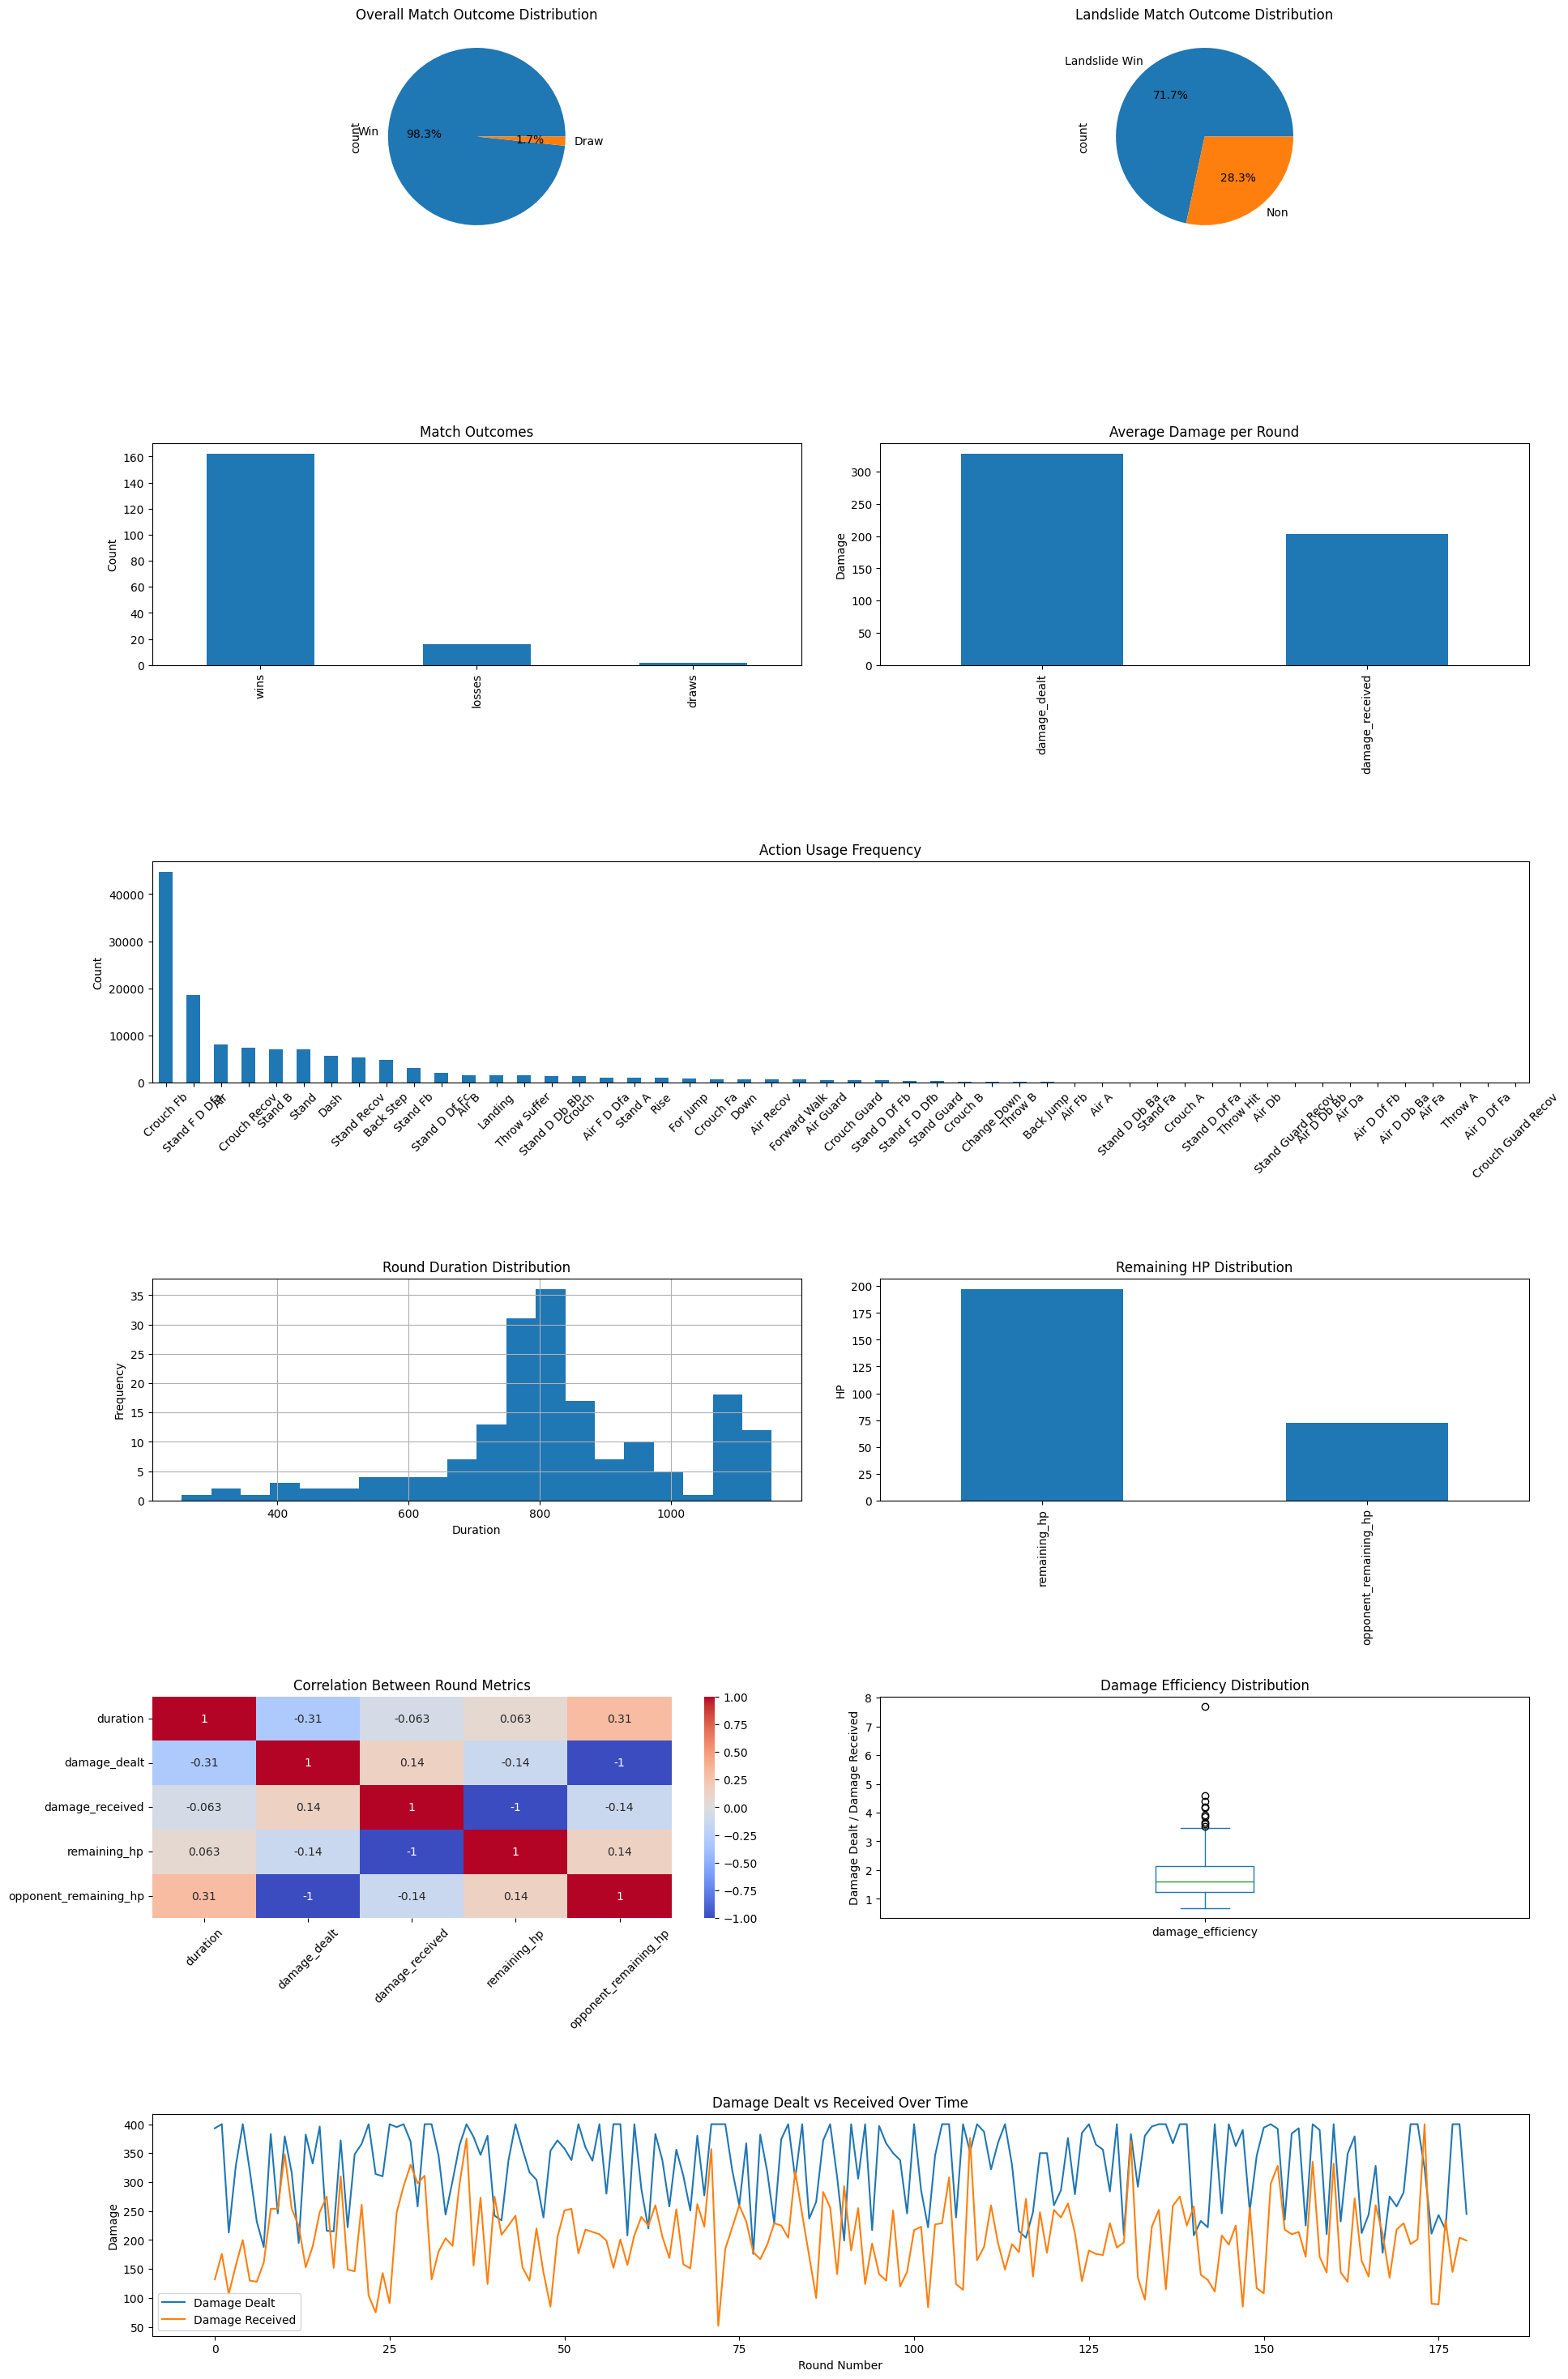

In [ ]:
analyse('stats_k=3/match-*.json')

**Analysis of Agent Performance, Pt. 1**

The ProbLog agent demonstrated remarkable effectiveness again, winning 98.3% of all matches, with 71.7% being landslide victories (winning all three rounds). This represents a significant but not complete dominance over the game MCTS opponent.

In comparative assessments against Marco's agent, the game's default agent exhibited superior performance across multiple metrics. Notably, the default agent consistently inflicted higher damage, secured a greater number of match victories, and presented a more formidable challenge to our agent.

Combat metrics show the ProbLog agent dealt approximately 300 units of damage per round, while the MCTS agent averaged around 200 units. The damage efficiency distribution (boxplot) reveals that most exchanges resulted in a damage ratio between 1.5 and 2.0, with some exceptional rounds reaching up to 7.0, indicating moments of particularly effective combat performance.
Action usage analysis reveals a highly skewed distribution, with the most frequent action being executed over 40,000 times same as with Marco's, followed by a sharp decline in usage for other moves. This suggests that the action `CROUCH_FB` is the most efficient to inflict damage, gain energy and win the games.

The round duration histogram shows an interesting bimodal distribution centered around 800 and 1000 time units, suggesting two distinct types of round conclusions: quick victories and more prolonged exchanges.

The temporal damage analysis (bottom graph) reveals dynamic combat patterns where the ProbLog agent (blue line) consistently maintained higher damage output compared to damage received (orange line). Notable fluctuations in both lines suggest active exchanges rather than one-sided dominance, though the ProbLog agent maintained tactical superiority throughout most encounters. Furthermore, the plot indicates the occurrence of rounds characterized by minimal damage inflicted by both agents. This observation suggests a potential pattern of cautious or avoidant behavior.



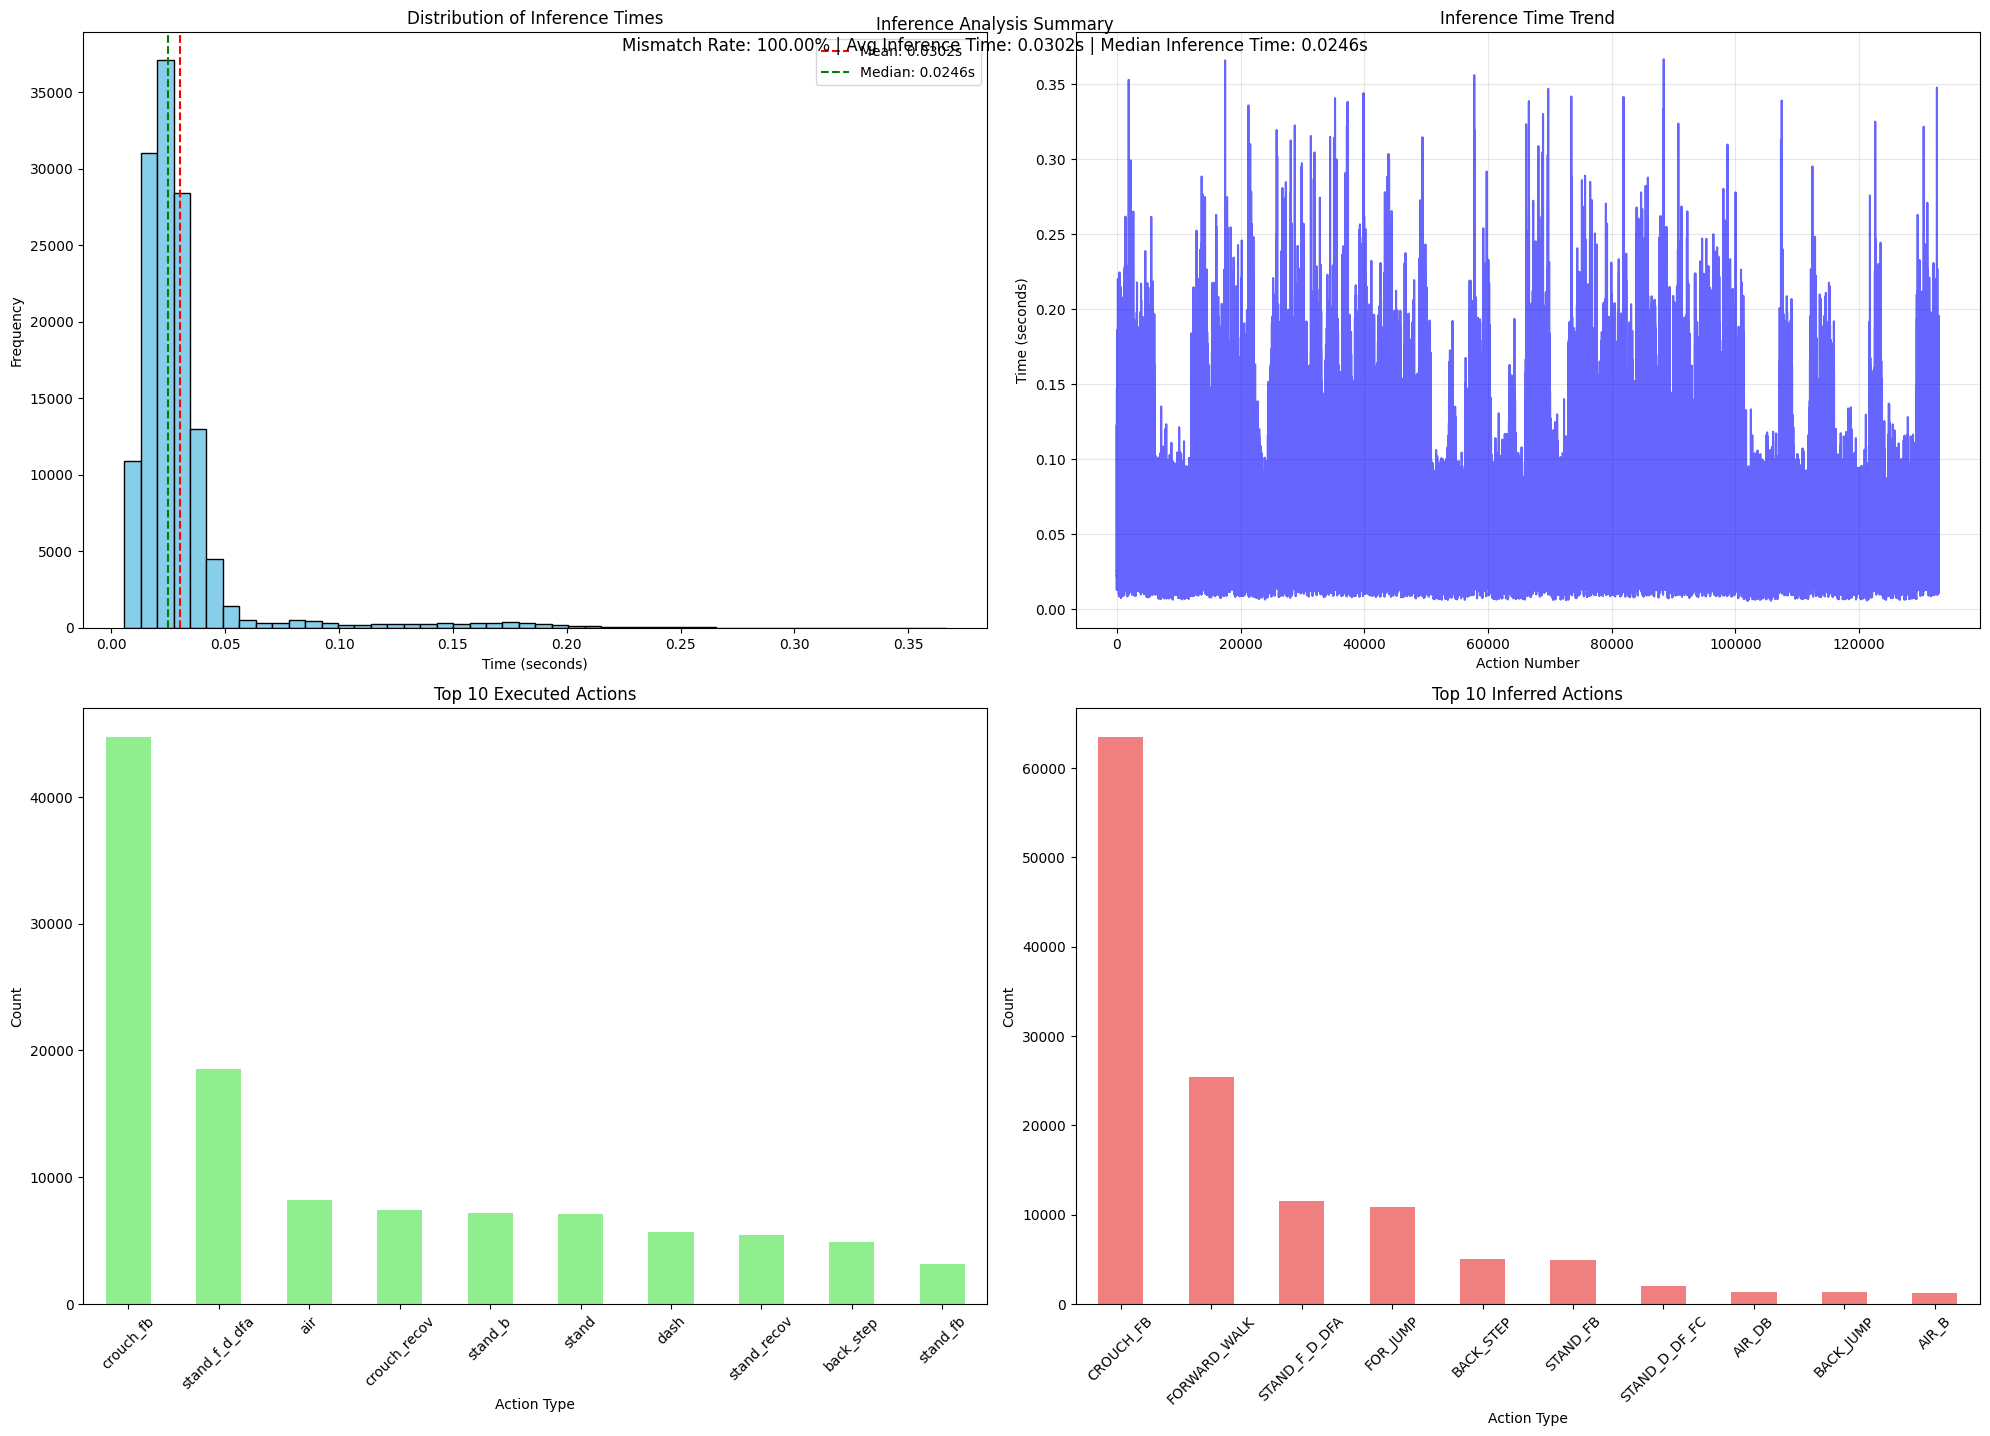


Detailed Statistics:
Action Mismatch Rate: 100.00%
Average Inference Time: 0.0302 seconds
Median Inference Time: 0.0246 seconds
Total Actions Analyzed: 132878


In [ ]:
analyze_inference_and_actions('stats_k=3/match-*.json')

**Analysis of Agent Performance, Pt. 1**

The inference time distribution (first plot) demonstrates highly efficient decision-making, with a median inference time of 0.0246 seconds and an average of 0.0302 seconds, showing slightly better performance than against the Marco's agent.

The time series (second plot) encloses approximately 120,000 actions, double the scale of our previous results. The temporal pattern exhibits consistent performance throughout extended gameplay sessions, with no significant degradation in response times, again. While the plot shows periodic spikes reaching up to 0.35 seconds, these represent a smaller fraction than the previous plot  of total actions and don't substantially impact overall agent responsiveness.

The action analysis reveals interesting patterns in both inferred and executed moves. The executed actions (green plot) show "CROUCH_FB" as the dominant strategy with over 40,000 executions, while the inferred actions (red plot) show an even stronger preference for this move with approximately 60,000 inferences. This behaviour is consistent throughout multiple agents. A comparative analysis of inferred actions between matches involving Marco's agent and the game's default agent reveals the adaptive capacity of our bot to adjust its strategy based on the opponent's playing style. The FightingICE default agent exhibits a greater tendency toward aerial combat, frequently jumping and executing maneuvers in the air. In response, our agent demonstrates a corresponding increase in the selection of both aerial actions and anti-air countermeasures, indicating an adaptive response tailored to the opponent's preferred tactics.

During our evaluation, we observed a specific challenge in our agent's predictive capabilities. It exhibited difficulty in anticipating opponent jump actions, frequently selecting the 'CROUCH_FB' action, which is ineffective against airborne opponents. This limitation highlights an area for potential improvement in future iterations of the agent's decision-making logic.